Kontrola linearity měření napětí
---
- Kenwood DLE 1041 mezi DC+ a DC-
- Diametral AC250K1D na 2 svorkách 3f vstupu
- odpojená zátěž (softwarová OVP se může pokusit zastavit turbínu maximální střídou)

In [1]:
import math
import time
import pandas as pd
import numpy as np
import pyvisa
from datetime import datetime
from tqdm import tqdm
from vetrnik import *
from AC250K1D import AC250K1D
from pathlib import Path

In [2]:
EXPERIMENT_DIR = Path("experiments") / "vetrnik-voltage-run2"
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
log = vetrnik_log_start(EXPERIMENT_DIR / "MQTT.log")

In [4]:
psu = AC250K1D("/dev/ttyUSB-AC250K1D", 1, timeout=2.0)
psu.get_id()

'TYPAC250K1D  VC0614'

In [5]:
psu.voltage = 0
time.sleep(.8)
psu.output = True

In [6]:
rm = pyvisa.ResourceManager()
dmm = rm.open_resource("ASRL/dev/ttyUSB-dle1041::INSTR", baud_rate=9600, read_termination='\r\n', write_termination='\n')
dmm.query("*IDN?")

'KENWOOD DLE 1041,0,1.22'

In [7]:
dmm.write("VDC")  # autorange

4

In [8]:
vetrnik_set("control/strategy", "control_MQTT")
vetrnik_set("control/contactor", "1")
vetrnik_set("power_board/duty", "0")
vetrnik_set("power_board/sw_enable", "1")
time.sleep(.5)
vetrnik_set("power_board/mode", "start")

In [9]:
# hardware OVP should trip @ ~109 V
# software OVP should trip @ 95V
VDC_max = 90
VAC_max = VDC_max / math.sqrt(2) + .6*2
VAC_max
# settings 60 VAC results in 65 VAC out

64.83961030678927

In [10]:
voltages = [2, 3, *range(5, 61, 5)]
voltages, len(voltages)

([2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], 14)

In [11]:
time.sleep(1)

In [12]:
data = []

for v in tqdm(voltages):
    dp = {
        "datetime": datetime.now(),
        "voltage_set": v,
    }
    vetrnik_set("control/contactor", "1")  # prevent timeout
    vetrnik_set("power_board/duty", "0")  # prevent timeout
    psu.voltage = v
    time.sleep(2)
    dp["voltage_get1"] = psu.voltage
    dp["voltage_dmm1"] = dmm.query("READ?")
    dp["time1"] = vetrnik_get("power_board/time")
    dp["voltage_vetrnik1"] = vetrnik_get("power_board/voltage")
    time.sleep(1)
    dp["voltage_get2"] = psu.voltage
    dp["voltage_dmm2"] = dmm.query("READ?")
    dp["time2"] = vetrnik_get("power_board/time")
    dp["voltage_vetrnik2"] = vetrnik_get("power_board/voltage")
    time.sleep(1)
    dp["voltage_get3"] = psu.voltage
    dp["voltage_dmm3"] = dmm.query("READ?")
    dp["time3"] = vetrnik_get("power_board/time")
    dp["voltage_vetrnik3"] = vetrnik_get("power_board/voltage")
    print(dp)
    data.append(dp)

  7%|███████▎                                                                                               | 1/14 [00:04<01:00,  4.63s/it]

{'datetime': datetime.datetime(2024, 7, 1, 22, 11, 10, 541995), 'voltage_set': 2, 'voltage_get1': 2, 'voltage_dmm1': ' 02.342e00 V DC   ', 'time1': '1354', 'voltage_vetrnik1': '2.1', 'voltage_get2': 2, 'voltage_dmm2': ' 02.369e00 V DC   ', 'time2': '1355', 'voltage_vetrnik2': '2.1', 'voltage_get3': 2, 'voltage_dmm3': ' 02.383e00 V DC   ', 'time3': '1357', 'voltage_vetrnik3': '2.1'}


 14%|██████████████▋                                                                                        | 2/14 [00:09<00:55,  4.61s/it]

{'datetime': datetime.datetime(2024, 7, 1, 22, 11, 15, 180022), 'voltage_set': 3, 'voltage_get1': 3, 'voltage_dmm1': ' 03.930e00 V DC   ', 'time1': '1359', 'voltage_vetrnik1': '3.6', 'voltage_get2': 3, 'voltage_dmm2': ' 03.957e00 V DC   ', 'time2': '1360', 'voltage_vetrnik2': '3.8', 'voltage_get3': 3, 'voltage_dmm3': ' 03.967e00 V DC   ', 'time3': '1361', 'voltage_vetrnik3': '3.8'}


 21%|██████████████████████                                                                                 | 3/14 [00:13<00:50,  4.60s/it]

{'datetime': datetime.datetime(2024, 7, 1, 22, 11, 19, 769974), 'voltage_set': 5, 'voltage_get1': 5, 'voltage_dmm1': ' 07.140e00 V DC   ', 'time1': '1363', 'voltage_vetrnik1': '6.8', 'voltage_get2': 5, 'voltage_dmm2': ' 07.156e00 V DC   ', 'time2': '1365', 'voltage_vetrnik2': '7.0', 'voltage_get3': 5, 'voltage_dmm3': ' 07.158e00 V DC   ', 'time3': '1366', 'voltage_vetrnik3': '7.0'}


 29%|█████████████████████████████▍                                                                         | 4/14 [00:18<00:45,  4.60s/it]

{'datetime': datetime.datetime(2024, 7, 1, 22, 11, 24, 360379), 'voltage_set': 10, 'voltage_get1': 10, 'voltage_dmm1': ' 014.39e00 V DC   ', 'time1': '1368', 'voltage_vetrnik1': '14.2', 'voltage_get2': 11, 'voltage_dmm2': ' 014.39e00 V DC   ', 'time2': '1369', 'voltage_vetrnik2': '14.2', 'voltage_get3': 11, 'voltage_dmm3': ' 014.40e00 V DC   ', 'time3': '1370', 'voltage_vetrnik3': '14.2'}


 36%|████████████████████████████████████▊                                                                  | 5/14 [00:23<00:41,  4.62s/it]

{'datetime': datetime.datetime(2024, 7, 1, 22, 11, 28, 949898), 'voltage_set': 15, 'voltage_get1': 16, 'voltage_dmm1': ' 022.47e00 V DC   ', 'time1': '1373', 'voltage_vetrnik1': '22.2', 'voltage_get2': 16, 'voltage_dmm2': ' 022.50e00 V DC   ', 'time2': '1374', 'voltage_vetrnik2': '22.2', 'voltage_get3': 16, 'voltage_dmm3': ' 022.51e00 V DC   ', 'time3': '1375', 'voltage_vetrnik3': '22.4'}


 43%|████████████████████████████████████████████▏                                                          | 6/14 [00:27<00:36,  4.61s/it]

{'datetime': datetime.datetime(2024, 7, 1, 22, 11, 33, 617683), 'voltage_set': 20, 'voltage_get1': 21, 'voltage_dmm1': ' 029.72e00 V DC   ', 'time1': '1377', 'voltage_vetrnik1': '29.4', 'voltage_get2': 21, 'voltage_dmm2': ' 029.82e00 V DC   ', 'time2': '1378', 'voltage_vetrnik2': '29.6', 'voltage_get3': 21, 'voltage_dmm3': ' 029.83e00 V DC   ', 'time3': '1380', 'voltage_vetrnik3': '29.6'}


 50%|███████████████████████████████████████████████████▌                                                   | 7/14 [00:32<00:32,  4.67s/it]

{'datetime': datetime.datetime(2024, 7, 1, 22, 11, 38, 209869), 'voltage_set': 25, 'voltage_get1': 26, 'voltage_dmm1': ' 037.00e00 V DC   ', 'time1': '1382', 'voltage_vetrnik1': '36.8', 'voltage_get2': 26, 'voltage_dmm2': ' 037.03e00 V DC   ', 'time2': '1383', 'voltage_vetrnik2': '36.9', 'voltage_get3': 27, 'voltage_dmm3': ' 037.09e00 V DC   ', 'time3': '1384', 'voltage_vetrnik3': '36.9'}


 57%|██████████████████████████████████████████████████████████▊                                            | 8/14 [00:37<00:27,  4.65s/it]

{'datetime': datetime.datetime(2024, 7, 1, 22, 11, 42, 997621), 'voltage_set': 30, 'voltage_get1': 32, 'voltage_dmm1': ' 045.33e00 V DC   ', 'time1': '1387', 'voltage_vetrnik1': '45.2', 'voltage_get2': 32, 'voltage_dmm2': ' 045.12e00 V DC   ', 'time2': '1388', 'voltage_vetrnik2': '45.0', 'voltage_get3': 32, 'voltage_dmm3': ' 045.12e00 V DC   ', 'time3': '1389', 'voltage_vetrnik3': '45.0'}


 64%|██████████████████████████████████████████████████████████████████▏                                    | 9/14 [00:41<00:23,  4.65s/it]

{'datetime': datetime.datetime(2024, 7, 1, 22, 11, 47, 594307), 'voltage_set': 35, 'voltage_get1': 38, 'voltage_dmm1': ' 053.30e00 V DC   ', 'time1': '1391', 'voltage_vetrnik1': '53.1', 'voltage_get2': 38, 'voltage_dmm2': ' 053.31e00 V DC   ', 'time2': '1393', 'voltage_vetrnik2': '53.3', 'voltage_get3': 38, 'voltage_dmm3': ' 053.41e00 V DC   ', 'time3': '1394', 'voltage_vetrnik3': '53.3'}


 71%|████████████████████████████████████████████████████████████████████████▊                             | 10/14 [00:46<00:18,  4.63s/it]

{'datetime': datetime.datetime(2024, 7, 1, 22, 11, 52, 261631), 'voltage_set': 40, 'voltage_get1': 43, 'voltage_dmm1': ' 060.85e00 V DC   ', 'time1': '1396', 'voltage_vetrnik1': '60.8', 'voltage_get2': 43, 'voltage_dmm2': ' 060.81e00 V DC   ', 'time2': '1397', 'voltage_vetrnik2': '60.8', 'voltage_get3': 43, 'voltage_dmm3': ' 060.60e00 V DC   ', 'time3': '1398', 'voltage_vetrnik3': '60.6'}


 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 11/14 [00:50<00:13,  4.62s/it]

{'datetime': datetime.datetime(2024, 7, 1, 22, 11, 56, 853579), 'voltage_set': 45, 'voltage_get1': 49, 'voltage_dmm1': ' 068.70e00 V DC   ', 'time1': '1400', 'voltage_vetrnik1': '68.7', 'voltage_get2': 49, 'voltage_dmm2': ' 068.79e00 V DC   ', 'time2': '1402', 'voltage_vetrnik2': '68.9', 'voltage_get3': 49, 'voltage_dmm3': ' 068.70e00 V DC   ', 'time3': '1403', 'voltage_vetrnik3': '68.7'}


 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 12/14 [00:55<00:09,  4.62s/it]

{'datetime': datetime.datetime(2024, 7, 1, 22, 12, 1, 437823), 'voltage_set': 50, 'voltage_get1': 54, 'voltage_dmm1': ' 075.96e00 V DC   ', 'time1': '1405', 'voltage_vetrnik1': '75.9', 'voltage_get2': 54, 'voltage_dmm2': ' 075.97e00 V DC   ', 'time2': '1406', 'voltage_vetrnik2': '76.0', 'voltage_get3': 54, 'voltage_dmm3': ' 076.00e00 V DC   ', 'time3': '1407', 'voltage_vetrnik3': '76.0'}


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▋       | 13/14 [01:00<00:04,  4.66s/it]

{'datetime': datetime.datetime(2024, 7, 1, 22, 12, 6, 55400), 'voltage_set': 55, 'voltage_get1': 60, 'voltage_dmm1': ' 084.07e00 V DC   ', 'time1': '1410', 'voltage_vetrnik1': '84.2', 'voltage_get2': 60, 'voltage_dmm2': ' 084.07e00 V DC   ', 'time2': '1411', 'voltage_vetrnik2': '84.2', 'voltage_get3': 60, 'voltage_dmm3': ' 084.08e00 V DC   ', 'time3': '1412', 'voltage_vetrnik3': '84.3'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [01:04<00:00,  4.64s/it]

{'datetime': datetime.datetime(2024, 7, 1, 22, 12, 10, 805534), 'voltage_set': 60, 'voltage_get1': 65, 'voltage_dmm1': ' 091.38e00 V DC   ', 'time1': '1414', 'voltage_vetrnik1': '91.5', 'voltage_get2': 65, 'voltage_dmm2': ' 091.40e00 V DC   ', 'time2': '1416', 'voltage_vetrnik2': '91.6', 'voltage_get3': 65, 'voltage_dmm3': ' 091.40e00 V DC   ', 'time3': '1417', 'voltage_vetrnik3': '91.6'}


In [13]:
psu.voltage = 0
psu.output = False
vetrnik_set("control/strategy", "control_shorted")

In [14]:
vetrnik_log_stop(log)
del log

In [15]:
psu.close()
rm.close()

In [16]:
df = pd.DataFrame(data)
df

,datetime,voltage_set,voltage_get1,voltage_dmm1,time1,voltage_vetrnik1,voltage_get2,voltage_dmm2,time2,voltage_vetrnik2,voltage_get3,voltage_dmm3,time3,voltage_vetrnik3
0,2024-07-01 22:11:10.541995,2,2,02.342e00 V DC,1354,2.1,2,02.369e00 V DC,1355,2.1,2,02.383e00 V DC,1357,2.1
1,2024-07-01 22:11:15.180022,3,3,03.930e00 V DC,1359,3.6,3,03.957e00 V DC,1360,3.8,3,03.967e00 V DC,1361,3.8
2,2024-07-01 22:11:19.769974,5,5,07.140e00 V DC,1363,6.8,5,07.156e00 V DC,1365,7.0,5,07.158e00 V DC,1366,7.0
3,2024-07-01 22:11:24.360379,10,10,014.39e00 V DC,1368,14.2,11,014.39e00 V DC,1369,14.2,11,014.40e00 V DC,1370,14.2
4,2024-07-01 22:11:28.949898,15,16,022.47e00 V DC,1373,22.2,16,022.50e00 V DC,1374,22.2,16,022.51e00 V DC,1375,22.4
5,2024-07-01 22:11:33.617683,20,21,029.72e00 V DC,1377,29.4,21,029.82e00 V DC,1378,29.6,21,029.83e00 V DC,1380,29.6
6,2024-07-01 22:11:38.209869,25,26,037.00e00 V DC,1382,36.8,26,037.03e00 V DC,1383,36.9,27,037.09e00 V DC,1384,36.9
7,2024-07-01 22:11:42.997621,30,32,045.33e00 V DC,1387,45.2,32,045.12e00 V DC,1388,45.0,32,045.12e00 V DC,1389,45.0
8,2024-07-01 22:11:47.594307,35,38,053.30e00 V DC,1391,53.1,38,053.31e00 V DC,1393,53.3,38,053.41e00 V DC,1394,53.3
9,2024-07-01 22:11:52.261631,40,43,060.85e00 V DC,1396,60.8,43,060.81e00 V DC,1397,60.8,43,060.60e00 V DC,1398,60.6


In [25]:
# decode DMM measurements
for col in [f"voltage_dmm{i}" for i in range(1,4)]:
    df[col+"_V"] = pd.to_numeric(df[col].str.strip().str.split(" ", n=1, expand=True)[0])

# vetrnik measurements from string to float
for col in [f"voltage_vetrnik{i}" for i in range(1,4)]:
    df[col] = pd.to_numeric(df[col])

df

,datetime,voltage_set,voltage_get1,voltage_dmm1,time1,voltage_vetrnik1,voltage_get2,voltage_dmm2,time2,voltage_vetrnik2,voltage_get3,voltage_dmm3,time3,voltage_vetrnik3,voltage_dmm1_V,voltage_dmm2_V,voltage_dmm3_V
0,2024-07-01 22:11:10.541995,2,2,02.342e00 V DC,1354,2.1,2,02.369e00 V DC,1355,2.1,2,02.383e00 V DC,1357,2.1,2.342,2.369,2.383
1,2024-07-01 22:11:15.180022,3,3,03.930e00 V DC,1359,3.6,3,03.957e00 V DC,1360,3.8,3,03.967e00 V DC,1361,3.8,3.930,3.957,3.967
2,2024-07-01 22:11:19.769974,5,5,07.140e00 V DC,1363,6.8,5,07.156e00 V DC,1365,7.0,5,07.158e00 V DC,1366,7.0,7.140,7.156,7.158
3,2024-07-01 22:11:24.360379,10,10,014.39e00 V DC,1368,14.2,11,014.39e00 V DC,1369,14.2,11,014.40e00 V DC,1370,14.2,14.390,14.390,14.400
4,2024-07-01 22:11:28.949898,15,16,022.47e00 V DC,1373,22.2,16,022.50e00 V DC,1374,22.2,16,022.51e00 V DC,1375,22.4,22.470,22.500,22.510
5,2024-07-01 22:11:33.617683,20,21,029.72e00 V DC,1377,29.4,21,029.82e00 V DC,1378,29.6,21,029.83e00 V DC,1380,29.6,29.720,29.820,29.830
6,2024-07-01 22:11:38.209869,25,26,037.00e00 V DC,1382,36.8,26,037.03e00 V DC,1383,36.9,27,037.09e00 V DC,1384,36.9,37.000,37.030,37.090
7,2024-07-01 22:11:42.997621,30,32,045.33e00 V DC,1387,45.2,32,045.12e00 V DC,1388,45.0,32,045.12e00 V DC,1389,45.0,45.330,45.120,45.120
8,2024-07-01 22:11:47.594307,35,38,053.30e00 V DC,1391,53.1,38,053.31e00 V DC,1393,53.3,38,053.41e00 V DC,1394,53.3,53.300,53.310,53.410
9,2024-07-01 22:11:52.261631,40,43,060.85e00 V DC,1396,60.8,43,060.81e00 V DC,1397,60.8,43,060.60e00 V DC,1398,60.6,60.850,60.810,60.600


In [18]:
df.to_csv(EXPERIMENT_DIR / "data.csv", index=False)

<Axes: xlabel='voltage_dmm1_V'>

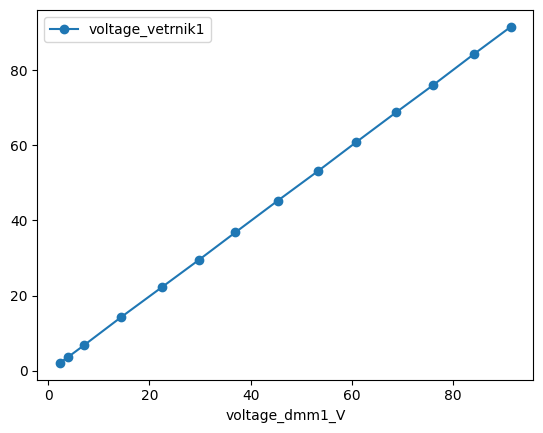

In [27]:
df.plot(x="voltage_dmm1_V", y="voltage_vetrnik1", style="-o")